In [1]:
import os
from pynq import Overlay
from pynq import Xlnk
import numpy as np
from struct import unpack                  # 30*30图片数据结构：62无用字节 + 30行 * 每行4字节（四个字节有两个比特是多余的）
import time

overlay = Overlay("./bit/forw_back_new_network.bit")
core = overlay.forw_back_0

In [2]:
def read_image(image_path):                 # 30*30图片数据结构：62无用字节 + 30行 * 每行4字节（四个字节有两个比特是多余的）
    img = open(image_path, 'rb')                # 打开一张图片
    img.seek(62)                                # 跳过前62个没用的字节
    nums = []
    and_list = [1, 2, 4, 8, 16, 32, 64, 128]    # 辅助从字节中提取比特
    for i in range(120):
        num = unpack("B", img.read(1))[0]       # 从头开始逐一读取120个字节
        for j in range(8):                     # 遍历8个bit
            if (i % 4 == 3) and (j >= 6):      # 检测到两个多余bit就跳过
                continue
            nums.append(((num & and_list[7 - j]) == and_list[7 - j]))  # 真实数据就放到列表后面
    return np.array(nums, dtype=int)

In [3]:
# 向PL端口输入数据——将xlnk接口地址写入PL端接口地址
# 地址可在HLS下solution1/impl/misc/drivers/forw_back_v0_0/src/xforw_back_hw.h可查
# 地址也可在SDK下system.hdf文件IP blocks present in the design部分Registers可查


# 导入导出参数 flag==0导入，flag>4导出
def Import_export_parameter(flag, conv1, conv2, fc1, fc2):
    core.write(0x10, flag)
    core.write(0x20, conv1)
    core.write(0x28, conv2)
    core.write(0x30, fc1)
    core.write(0x38, fc2)
    core.write(0x00, 0x01)
    while(core.read(0x00)!=4):
        i = 1
    return 0

# 导入一张图像 flag==1
def Import_a_image(flag, in_d):
    core.write(0x10, flag)
    core.write(0x18, in_d)
    core.write(0x00, 0x01)
    while(core.read(0x00)!=4):  # 如果0x00!=4就代表PL端还在运行
        i = 1
    return 0

# 开始测试 flag==2
def Begin_test(flag):
    core.write(0x10, flag)
    core.write(0x00, 0x01)
    while(core.read(0x00)!=4):  # 如果0x00!=4就代表PL端还在运行
        i = 1
    return 0

# 开始训练 flag==3
def Begin_train(flag, label, lr):
    core.write(0x10, flag)
    core.write(0x48, label)
    core.write(0x50, lr)
    core.write(0x00, 0x01)
    while(core.read(0x00)!=4):
        i = 1
    return 0

# 导出结果 flag==4
def Export_result(flag, out):
    core.write(0x10, flag)
    core.write(0x40, out)
    core.write(0x00, 0x01)
    while(core.read(0x00)!=4):
        i = 1
    return 0

In [4]:
def max10(data):          # 取最大值函数
    for i in range(10):
        if(data[i] == max(data)):
            location = i
            break
    return location

In [5]:
xlnk = Xlnk()            # 该接口必须申请内存后才能被IP使用，可以使用xlnk来申请一段连续内存缓冲区，该缓冲区允许PS跟PL之间进行有效的数据传输

# 给每个接口分配空间
data_in = xlnk.cma_array(shape=(30*30,), dtype=np.float32)
conv1 = xlnk.cma_array(shape=(9,), dtype=np.float32)
conv2 = xlnk.cma_array(shape=(9,), dtype=np.float32)
fc1 = xlnk.cma_array(shape=(36*20,), dtype=np.float32)
fc2 = xlnk.cma_array(shape=(20*10,), dtype=np.float32)
data_out = xlnk.cma_array(shape=(10,), dtype=np.float32)


# 打开网络参数文件
para = open("./NetworkParameters_newnetwork.bin", "rb")

# 读取卷积核参数
for i in range(9):
    data = para.read(4)
    conv1[i] = unpack("f", data)[0]
for i in range(9):
    data = para.read(4)
    conv2[i] = unpack("f", data)[0]
    
# 读取全连接系数矩阵参数
for i in range(36*20):
    data = para.read(4)
    fc1[i] = unpack("f", data)[0]
for i in range(20*10):
    data = para.read(4)
    fc2[i] = unpack("f", data)[0]

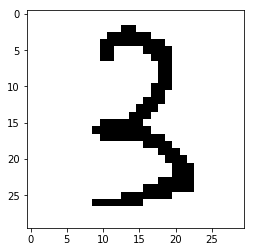

Prediction result is: 3
Prediction probability is: 0.9267924


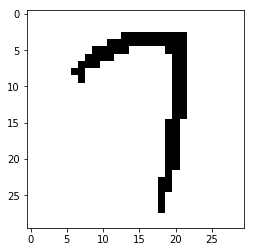

Prediction result is: 7
Prediction probability is: 0.9479632


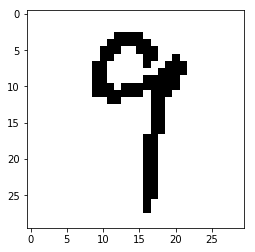

Prediction result is: 9
Prediction probability is: 0.86237395


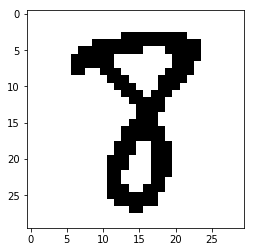

Prediction result is: 8
Prediction probability is: 0.7231446


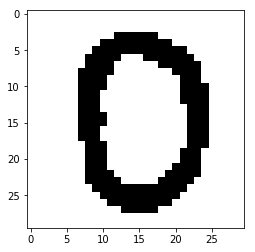

Prediction result is: 0
Prediction probability is: 0.9999713


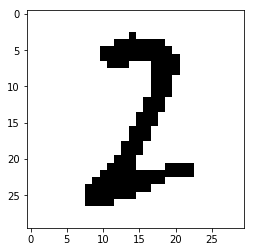

Prediction result is: 2
Prediction probability is: 0.96170765


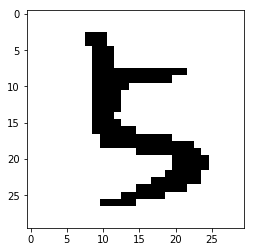

Prediction result is: 5
Prediction probability is: 0.99554616


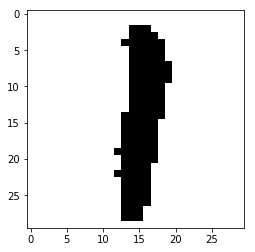

Prediction result is: 1
Prediction probability is: 0.8671733


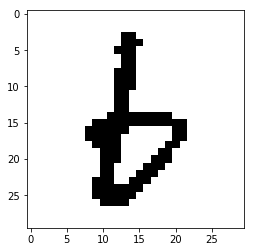

Prediction result is: 6
Prediction probability is: 0.99678534


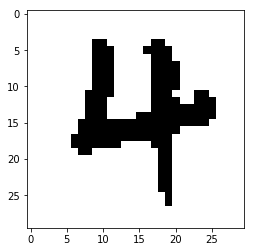

Prediction result is: 4
Prediction probability is: 0.98580307
Running time: 0.0006501674652099609 Seconds


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_image_dir_path = './Training_set/Test_set/'
test_images = os.listdir(test_image_dir_path)

# 0 导入初始化参数
Import_export_parameter(0, conv1.physical_address, conv2.physical_address, fc1.physical_address, fc2.physical_address)

for test_image in test_images:
    test_image_path = test_image_dir_path + test_image
    picture_data = read_image(test_image_path)
    for i in range(30*30):
        data_in[i] = picture_data[i]
    # 1 导入一张图片数据
    Import_a_image(1, data_in.physical_address)
    start = time.time()
    # 3 开始测试
    Begin_test(2)
    end = time.time()
    # 4 导出训练结果
    Export_result(4, data_out.physical_address)
    
    # print('Picture name is:',test_image,'   Prediction result is:',max10(data_out),'   Prediction probability is:',data_out[max10(data_out)])
    frame = mpimg.imread(test_image_dir_path + test_image)             # 读取待识别图片
    frame.shape
    plt.imshow(frame)                                                  # 显示图片
    plt.show()
    print('Prediction result is:',max10(data_out))
    print('Prediction probability is:',data_out[max10(data_out)])
print('Running time: %s Seconds'%((end-start)))
